# Melhorando o Treinamento

Nesta seção vamos aplicar técnicas de regularização para melhorar a generalização do modelo.

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Preparação dos Dados

A regularização via dados busca aproximar a distribuição empírica da distribuição real $P_{data}(x)$. Utilizamos `torchvision.transforms` para aplicar perturbações afins e rotações aleatórias apenas no conjunto de treino, mantendo a validação inalterada (apenas normalizada).

Restringiremos o dataset MNIST a 5000 amostras de treino e 1000 de validação para simular escassez de dados.

In [55]:
batch_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
full_val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=val_transform)

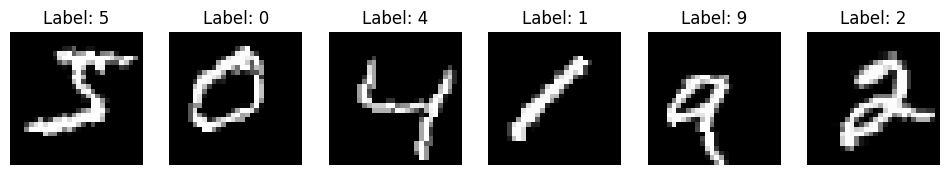

In [56]:
def plot_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))
    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

plot_samples(full_train_dataset)

In [57]:
train_indices = torch.arange(0, 2000)
val_indices = torch.arange(0, 1000)

train_subset = Subset(full_train_dataset, train_indices)
val_subset = Subset(full_val_dataset, val_indices)

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

print(f"Training size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")

Training size: 2000
Validation size: 1000


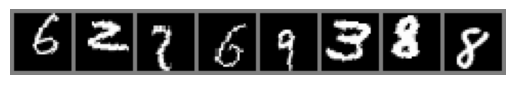

In [58]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))

# Arquitetura MLP

Implementação de uma MLP com camadas de **Dropout**. Matematicamente, durante o treino, o Dropout aplica uma máscara de Bernoulli $r^{(l)} \sim \text{Bernoulli}(p)$ às ativações $h^{(l)}$, resultando em $\tilde{h}^{(l)} = r^{(l)} \odot h^{(l)}$. Isso previne a co-adaptação complexa dos neurônios.

In [59]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super().__init__()
        self.flatten = nn.Flatten()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            
            nn.Linear(hidden_size // 2, num_classes)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [60]:
input_dim = 28 * 28
hidden_dim = 512
output_dim = 10
dropout_rate = 0.5

model = MLP(input_dim, hidden_dim, output_dim, dropout_rate).to(device)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


## Treinamento com Weight Decay (Regularização L2)

O loop de treinamento integra a penalização **Weight Decay**. A função de custo efetiva torna-se $\mathcal{L}_{total} = \mathcal{L}_{CE} + \frac{\lambda}{2} ||w||^2$, onde $\lambda$ é controlado pelo parâmetro `weight_decay` no otimizador Adam.

In [61]:
learning_rate = 0.001
weight_decay_lambda = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_lambda)

In [62]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
num_epochs = 20

for epoch in range(num_epochs):
    # --- Fase de Treinamento ---
    model.train() # Habilita Dropout e cálculo de gradientes
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zerar gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass e otimização
        loss.backward()
        optimizer.step()
        
        # Estatísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # --- Fase de Validação ---
    model.eval() # Desabilita Dropout
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad(): # Desabilita cálculo de gradientes para economizar memória
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    print(f"Época [{epoch+1}/{num_epochs}] | "
          f"Perda Treino: {epoch_train_loss:.4f} Acurácia: {epoch_train_acc:.2f}% | "
          f"Perda Val: {epoch_val_loss:.4f} Acurácia: {epoch_val_acc:.2f}%")

Época [1/20] | Perda Treino: 2.2137 Acurácia: 18.20% | Perda Val: 1.8215 Acurácia: 49.10%
Época [2/20] | Perda Treino: 1.8503 Acurácia: 35.40% | Perda Val: 1.2742 Acurácia: 66.00%
Época [3/20] | Perda Treino: 1.6726 Acurácia: 43.20% | Perda Val: 1.0716 Acurácia: 69.30%
Época [4/20] | Perda Treino: 1.5886 Acurácia: 45.95% | Perda Val: 0.9561 Acurácia: 74.60%
Época [5/20] | Perda Treino: 1.4352 Acurácia: 52.45% | Perda Val: 0.8007 Acurácia: 76.10%
Época [6/20] | Perda Treino: 1.4081 Acurácia: 53.70% | Perda Val: 0.8184 Acurácia: 74.90%
Época [7/20] | Perda Treino: 1.3186 Acurácia: 56.25% | Perda Val: 0.8283 Acurácia: 75.90%
Época [8/20] | Perda Treino: 1.2591 Acurácia: 57.40% | Perda Val: 0.7404 Acurácia: 79.50%
Época [9/20] | Perda Treino: 1.2216 Acurácia: 59.40% | Perda Val: 0.6899 Acurácia: 78.90%
Época [10/20] | Perda Treino: 1.2298 Acurácia: 58.85% | Perda Val: 0.6952 Acurácia: 79.10%
Época [11/20] | Perda Treino: 1.1601 Acurácia: 60.05% | Perda Val: 0.6402 Acurácia: 81.30%
Época [1

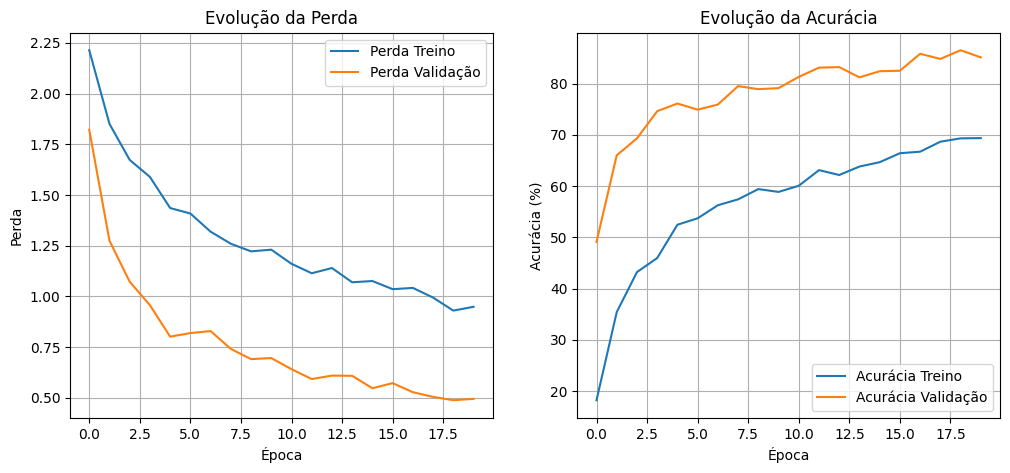

In [63]:
plt.figure(figsize=(12, 5))

# Gráfico de Perda
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Perda Treino')
plt.plot(val_losses, label='Perda Validação')
plt.title('Evolução da Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

# Gráfico de Acurácia
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Acurácia Treino')
plt.plot(val_accs, label='Acurácia Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)

plt.show()

## Inferência

Teste qualitativo final utilizando o modelo em modo de avaliação (`model.eval()`) para predição em amostras não vistas do conjunto de validação.

Rótulo Real:  7 2 1 0 4
Predição:     7 2 1 0 4


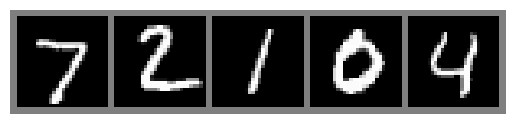

In [64]:
# Obtendo um batch de validação
dataiter_val = iter(val_loader)
images_val, labels_val = next(dataiter_val)

# Selecionando as primeiras 5 imagens
images_sample = images_val[:5].to(device)
labels_sample = labels_val[:5]

# Inferência
model.eval()
with torch.no_grad():
    outputs = model(images_sample)
    _, predictions = torch.max(outputs, 1)

# Visualização dos resultados
print("Rótulo Real: ", " ".join(f'{labels_sample[j].item()}' for j in range(5)))
print("Predição:    ", " ".join(f'{predictions[j].item()}' for j in range(5)))

imshow(torchvision.utils.make_grid(images_sample.cpu()))